## A. Data reading and Data Analysis

*Notes:* In this notebook, I briefly mention the steps I followed for completing the project. A more detailed analysis exists on the respective report pdf.<br>
I keep here all of the code I used during my experiments, event though it may not be used for the final model.

In [ ]:
import pandas as pd 
import numpy as np
import re 
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import STOPWORDS
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import emoji
import torch
import warnings
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import optuna
import random

#from nltk.tokenize import TweetTokenizer
#from gensim.models import Word2Vec

# kaggle
import shutil

Random  seed for reproducibility

In [47]:
SEED = 43 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Reading the datasets

In [48]:
train_df = pd.read_csv("data/train_dataset.csv")
test_df = pd.read_csv("data/test_dataset.csv")
val_df = pd.read_csv("data/val_dataset.csv")



# supress warnings
warnings.filterwarnings('ignore')

############ kaggle ############ 
# train_df = pd.read_csv("/kaggle/input/twitter-hw2/train_dataset.csv")
# test_df = pd.read_csv("/kaggle/input/twitter-hw2/test_dataset.csv")
# val_df = pd.read_csv("/kaggle/input/twitter-hw2/val_dataset.csv")
############ kaggle ############


print(f"{train_df.head(20)}\n")
train_df.describe()

        ID                                               Text  Label
0   189385      @whoisralphie dude  I'm so bummed ur leaving!      0
1    58036  oh my god, a severed foot was foun in a wheely...      0
2   190139  I end up &quot;dog dialing&quot; sumtimes. Wha...      1
3    99313                         @_rachelx meeeee toooooo!       0
4   157825  I was hoping I could stay home and work today,...      0
5   130560  says plurk karma finally reached the 50s. stil...      0
6   121871  Good to hear it @Arth This is a bit more, but ...      1
7    86813  @davorg in that case im gonna start tweeting a...      1
8   197517          @belunyc its alright love, how are you?        1
9     6937  @brightondoll haha that has to be the best ana...      1
10   92703  @AlpacaFarmgirl Biscuit is our cat. We've had ...      0
11  197003  @1capplegate I'm so sad about Sam Who  it was ...      0
12   23724  trying to stay healthy. 2 of 4 of this Devine ...      0
13   23205  My bro stole my big ba

,ID,Label
count,148388.000000,148388.000000
mean,106024.578699,0.500013
std,61150.300085,0.500002
min,0.000000,0.000000
25%,53237.500000,0.000000
50%,105998.000000,1.000000
75%,158927.250000,1.000000
max,211981.000000,1.000000


We will now try to analyze our data. To achieve that, we will use some WordClouds, plots and find sentiment distribution.

#### Sentiment distribution

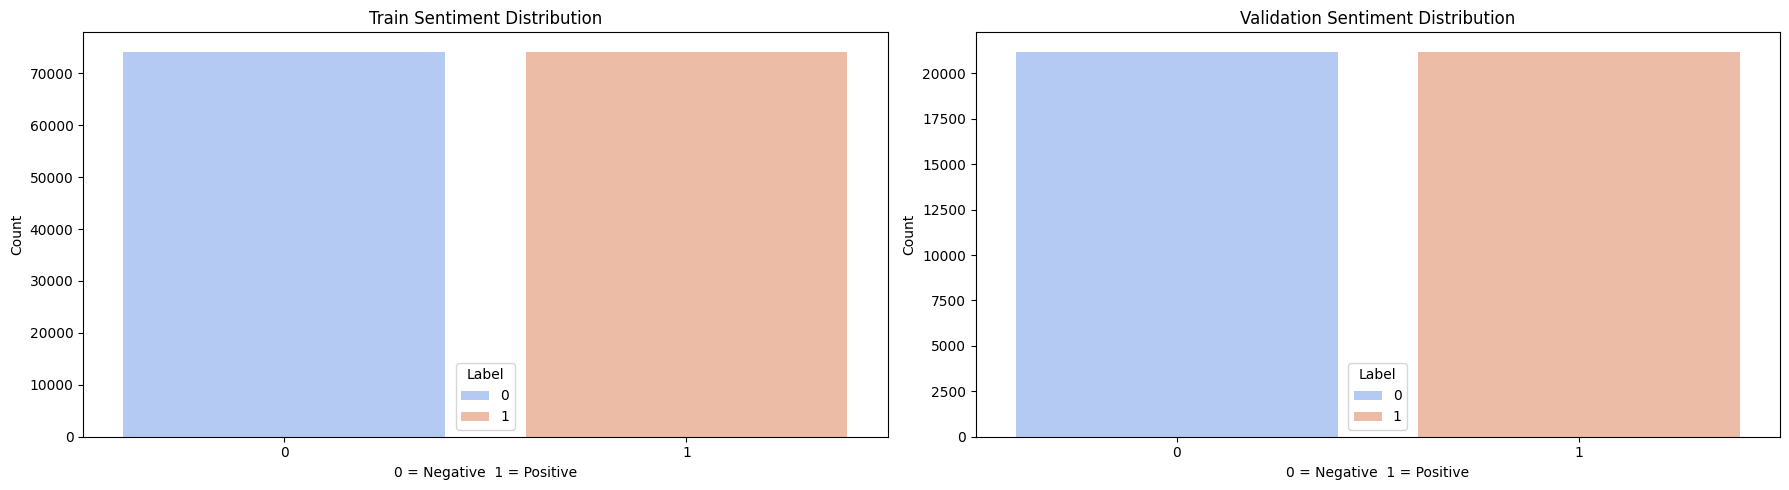

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  
for ax, df, title in zip(axes, [train_df, val_df], ["Train", "Validation"]):
    sns.countplot(x=df["Label"], hue=df["Label"], palette="coolwarm", ax=ax)
    ax.set_title(f"{title} Sentiment Distribution")
    ax.set_xlabel("0 = Negative  1 = Positive")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Most frequent words 

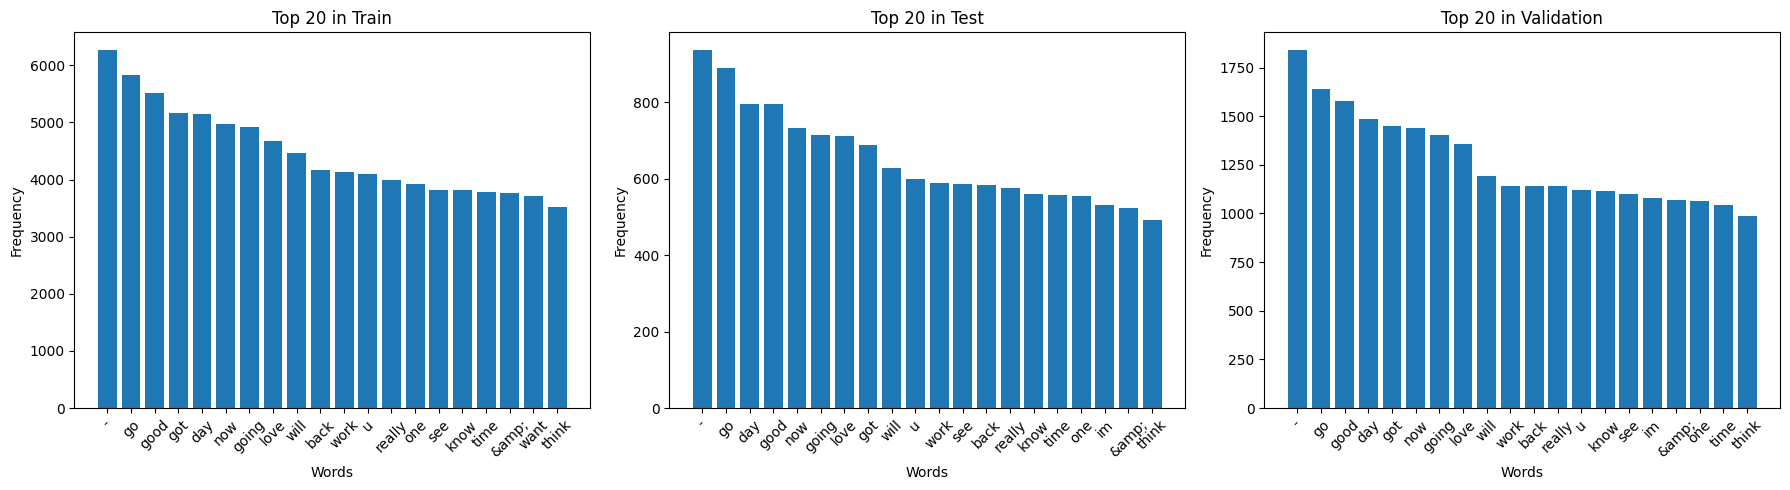

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, df, title in zip(axes, [train_df, test_df, val_df], ["Train", "Test", "Validation"]):
    allWords = " ".join(df["Text"]).split()
    wordFreq = Counter([word for word in allWords if word.lower() not in STOPWORDS])
    
    words, counts = zip(*wordFreq.most_common(20))
    ax.bar(words, counts)
    ax.set_xticklabels(words, rotation=45)
    ax.set_xlabel("Words")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Top 20 in {title}")

plt.tight_layout()
plt.show()

#### WordClouds

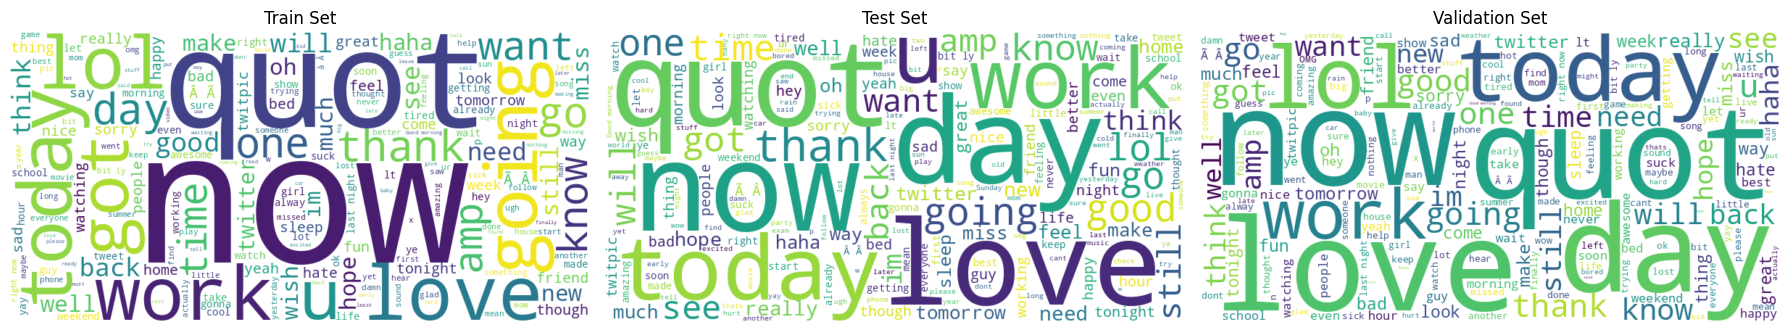

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, df, title in zip(axes, [train_df, test_df, val_df], ["Train", "Test", "Validation"]):
    text = " ".join(df["Text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{title} Set")

plt.tight_layout()
plt.show()

From the above data analysis, we can see that there is too much noise on our datasets and we must apply specific preprocessing steps to clean the text and get a better performance for our **BERT** models

## B. Data preprocessing

**preprocess()** func for the data-preprocessing

In [52]:
def preprocess(text):
    # contractions
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'re", " are", text)
    # urls
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # html
    text = re.sub(r"&\w+;", "", text)
    # mentions 
    text = re.sub(r"@\w+", "@user", text)
    # lower
    text = text.lower()
    # punctuation
    text = re.sub(r"[^a-zA-Z\s!?@]", "", text)
    # whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # emojis
    text = emoji.demojize(text, delimiters=(" ", " "))
    # normalize
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    
    # remove non-english
    text = re.sub(r"[^a-zA-Z\s!?@]", "", text)

    return text

**remove_stopwords()** func removes the stopwords for the given text. <br>
We will only use it if removing them boosts our model's performance.

In [53]:
customStop = {'im', 'u', 'them', 'this', 'that', 'these', 'those', 'and'}

def remove_stopwords(text):
    stopWords = set(stopwords.words('english'))
    stopWords.update(customStop)
    wordToks = word_tokenize(text.lower())  
    newText = [word for word in wordToks if word not in stopWords and word.isalnum()]
    return ' '.join(newText)

**lemm_text()** and **stem_text()** are used for text **lemmatization** and **stemming**. <br>
Again, we will only use these techniques if they boost our model's performance.

In [54]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download("wordnet")

############ KAGGLE ############
# nltk_data_path = "/root/nltk_data/corpora/wordnet"
# kaggle_dataset_path = "/kaggle/input/wordnet/wordnet"
# shutil.copytree(kaggle_dataset_path, nltk_data_path, dirs_exist_ok=True)
############ KAGGLE ############


def lemmatize_text(text):
    words = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in words])

def stem_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

[nltk_data] Downloading package wordnet to /home/hlias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Apply preprocessing

In [55]:
#nltk.download("punkt")
#nltk.download('punkt_tab')

# preprocess
train_df["Text"] = train_df["Text"].apply(preprocess)
val_df["Text"] = val_df["Text"].apply(preprocess)
test_df["Text"] = test_df["Text"].apply(preprocess)

# drop any rows that preprocess func returned as None
# train_df = train_df.dropna(subset=["Text"]).reset_index(drop=True)
# val_df = val_df.dropna(subset=["Text"]).reset_index(drop=True)

#stopwords removal
# train_df["Text"] = train_df["Text"].apply(remove_stopwords)
# val_df["Text"] = val_df["Text"].apply(remove_stopwords)
# test_df["Text"] = test_df["Text"].apply(remove_stopwords)


# stemming
# train_df["Text"] = train_df["Text"].apply(stem_text)
# val_df["Text"] = val_df["Text"].apply(stem_text)
# test_df["Text"] = test_df["Text"].apply(stem_text)

# lemmatize
# train_df["Text"] = train_df["Text"].apply(lemmatize_text)
# val_df["Text"] = val_df["Text"].apply(lemmatize_text)
# test_df["Text"] = test_df["Text"].apply(lemmatize_text)

print(f"{train_df.head(20)}\n")
train_df.describe()


        ID                                               Text  Label
0   189385              @user dude i am so bummed ur leaving!      0
1    58036  oh my god a severed foot was foun in a wheely ...      0
2   190139  i end up dog dialing sumtimes whats dog dialin...      1
3    99313                                       @user me to!      0
4   157825  i was hoping i could stay home and work today ...      0
5   130560  says plurk karma finally reached the s still n...      0
6   121871  good to hear it @user this is a bit more but a...      1
7    86813  @user in that case im gonna start tweeting abo...      1
8   197517                @user its alright love how are you?      1
9     6937  @user haha that has to be the best analogy eve...      1
10   92703  @user biscuit is our cat we have had him for y...      0
11  197003  @user i am so sad about sam who it was my favo...      0
12   23724  trying to stay healthy of of this devine famil...      0
13   23205  my bro stole my big ba

,ID,Label
count,148388.000000,148388.000000
mean,106024.578699,0.500013
std,61150.300085,0.500002
min,0.000000,0.000000
25%,53237.500000,0.000000
50%,105998.000000,1.000000
75%,158927.250000,1.000000
max,211981.000000,1.000000


## Vectorization